In [1]:
import rasterio as rio
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from rasterstats import zonal_stats
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

raster_dir = '/home/mcoving/Dropbox/sync/projects/Dolines/comparison_data/chelsa_v2/envicloud/chelsa/chelsa_V2/GLOBAL/climatologies/1981-2010/bio/'

raster_key = pd.read_excel('raster-data-key.xlsx', index_col=0)

p_karst_df = gpd.read_file('share/analysis-layers/processed_hucs.shp')
# Raster data is in EPSG:4326
p_karst_df_4326 = p_karst_df.to_crs("4326")

def add_raster_stats_to_df(df, parameter, raster_dir=raster_dir, raster_key=raster_key):
    raster_filename = raster_key['filename'][parameter]
    full_raster_path = os.path.join(raster_dir, raster_filename)
    scale = raster_key['scale'][parameter]
    offset = raster_key['offset'][parameter]

    with rio.open(full_raster_path) as src:
        affine = src.transform
        array = src.read(1)
        df_zonal_stats = pd.DataFrame(zonal_stats(p_karst_df_4326, array, affine=affine, all_touched=True))
        df[parameter] = df_zonal_stats['mean'].values * scale + offset
    
    return df

# pretty print key
raster_key


,scale,offset,filename
parameter,,,
mean annual temp,0.10,-273.15,CHELSA_bio1_1981-2010_V.2.1.tif
mean diurnal temp range,0.10,0.00,CHELSA_bio2_1981-2010_V.2.1.tif
isothermality,0.10,0.00,CHELSA_bio3_1981-2010_V.2.1.tif
temperature seasonality,0.10,0.00,CHELSA_bio4_1981-2010_V.2.1.tif
annual precipitation,0.10,0.00,CHELSA_bio12_1981-2010_V.2.1.tif
precipitation seasonality,0.10,0.00,CHELSA_bio15_1981-2010_V.2.1.tif
net primary productivity,0.10,0.00,CHELSA_npp_1981-2010_V.2.1.tif
monthly mean pet,0.01,0.00,CHELSA_pet_penman_mean_1981-2010_V.2.1.tif


In [2]:
for param in raster_key.index:
    print("Processing " + param +'...')
    p_karst_df_4326 = add_raster_stats_to_df(p_karst_df_4326, param)

Processing mean annual temp...


/home/mcoving/anaconda3/envs/geo_env/lib/python3.11/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


Processing mean diurnal temp range...
Processing isothermality...
Processing temperature seasonality...
Processing annual precipitation...
Processing precipitation seasonality...
Processing net primary productivity...
Processing monthly mean pet...


In [3]:
p_karst_df_4326.to_file('processed_hucs_with_climate_4326.shp')

/tmp/ipykernel_1108181/1967637734.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  p_karst_df_4326.to_file('processed_hucs_with_climate_4326.shp')


In [11]:
p_karst = p_karst_df_4326.p_karst
indep_vars = raster_key.index.values
controls_df = p_karst_df_4326[indep_vars]
controls_df

,mean annual temp,mean diurnal temp range,isothermality,temperature seasonality,annual precipitation,precipitation seasonality,net primary productivity,monthly mean pet
0,19.050000,10.500000,0.376500,647.966667,1151.316667,20.400000,1564.133333,108.348333
1,9.750000,9.383333,0.248833,999.800000,919.083333,32.950000,1334.016667,91.533333
2,7.079577,9.250704,0.227394,1097.788732,869.397183,49.539437,1152.078873,84.902254
3,6.800602,9.218072,0.226373,1099.648193,838.373494,47.892771,1128.595181,82.448675
4,6.900000,9.200000,0.225000,1107.800000,834.100000,48.350000,1136.900000,84.380000
...,...,...,...,...,...,...,...,...
29063,10.123485,8.072727,0.228962,958.203030,952.582576,20.548485,1369.368939,89.584091
29064,10.171918,8.331507,0.235795,952.552055,953.108219,20.894521,1369.916438,90.368219
29065,10.350000,6.043750,0.176188,1005.928125,1082.531250,22.975000,1437.500000,91.606875
29066,10.417742,7.674194,0.217419,979.367742,1059.496774,25.448387,1443.529032,83.995806


In [14]:
p_karst

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
29063    0.0
29064    0.0
29065    0.0
29066    0.0
29067    0.0
Name: p_karst, Length: 29068, dtype: float64

In [7]:
def make_displot(param, 
                 p_karst, 
                 controls_df, 
                 trim_zero=True, 
                 set_zero_to=None,
                 xlabel=None, 
                 ylabel='Percentage karst drained', 
                 log_scale=(False,True),
                 calculate_correlation='Spearman',):
    if set_zero_to is not None:
        p_karst[p_karst==0] = set_zero_to
    
    if trim_zero:
        non_zero_p_karst = p_karst>0
        x = controls_df[param][non_zero_p_karst]
        y = p_karst[non_zero_p_karst]
    else:
        x = controls_df[param]
        y = p_karst
    

    sns.displot(x=x,
            y=y,
            log_scale=log_scale,
            )
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    rstring = None
    if calculate_correlation == 'Spearman':
        r, p = spearmanr(x, y)
        rstring = 'rho='+str(r)[:5]
    if calculate_correlation == 'Pearson':
        r, p = pearsonr(x, y)
        rstring = 'R='+str(r)[:5]
    if rstring is not None:
        ax = plt.gca()
        plt.text(0.05,0.95, rstring, transform = ax.transAxes)



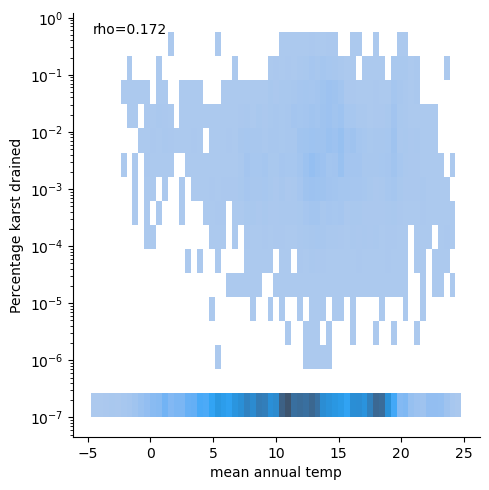

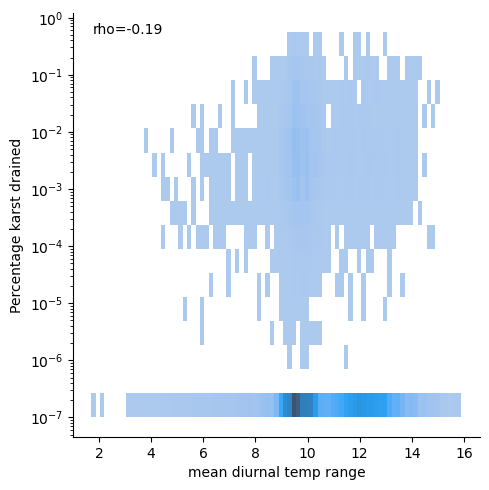

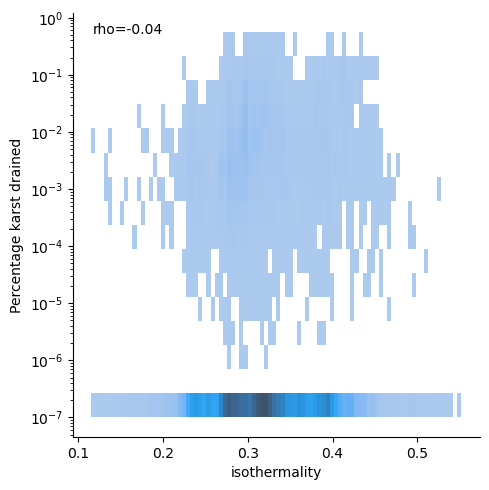

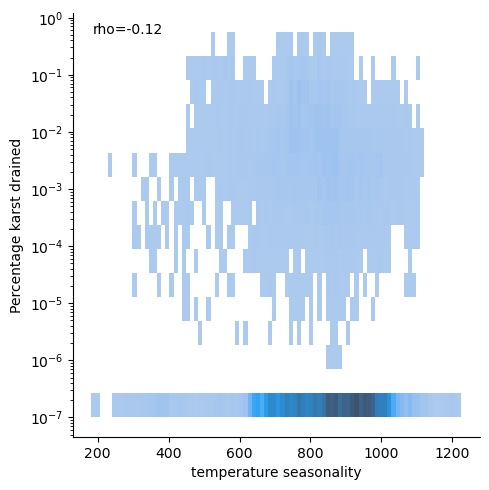

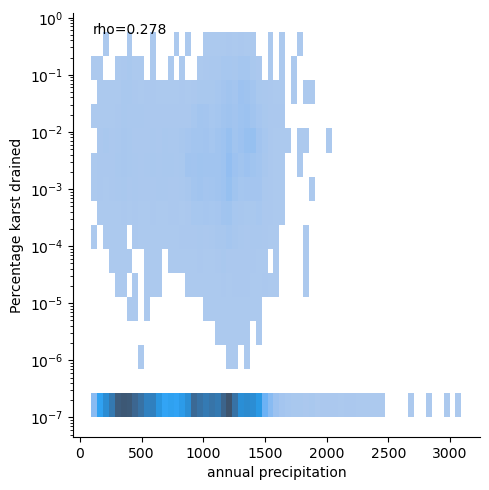

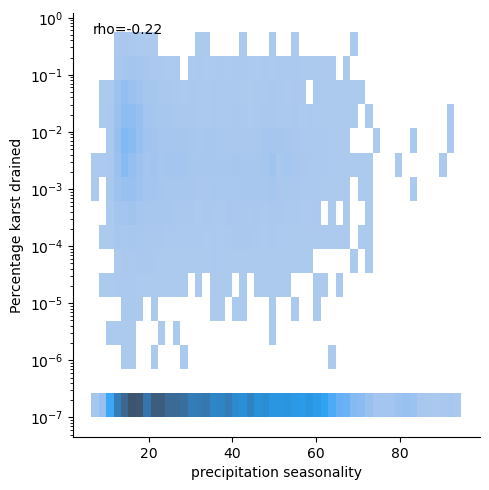

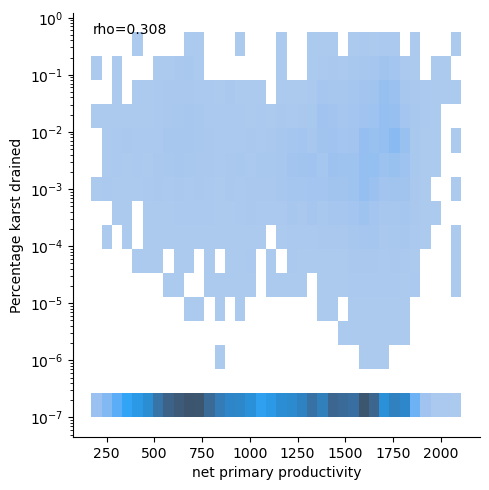

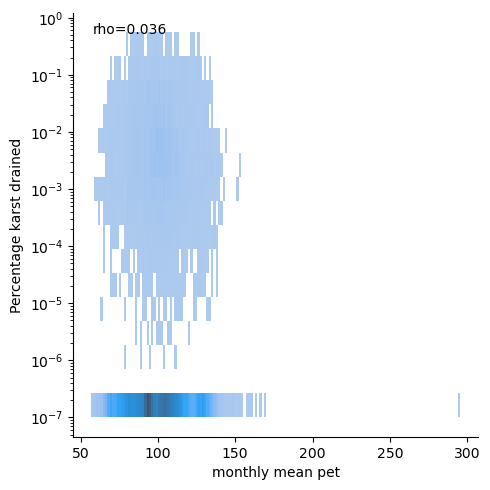

In [9]:
for param in raster_key.index:
     make_displot(param, 
             p_karst.copy(), 
             controls_df,
             trim_zero=False,
             set_zero_to=1e-7
        )

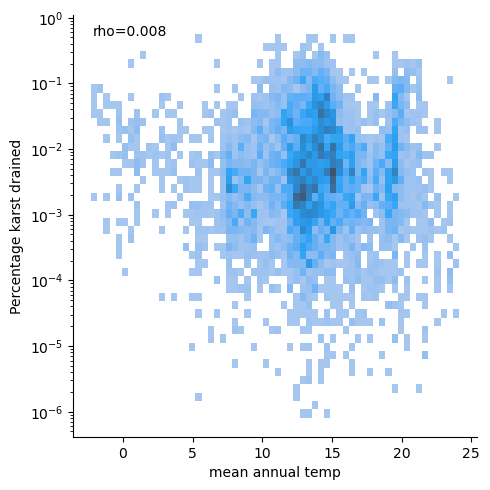

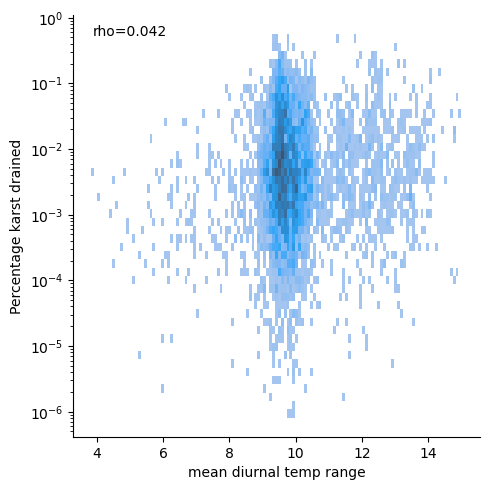

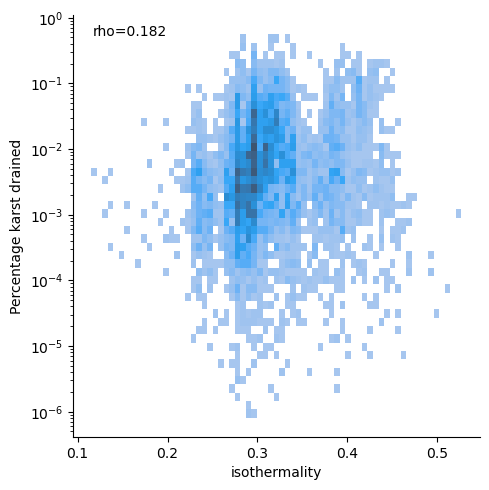

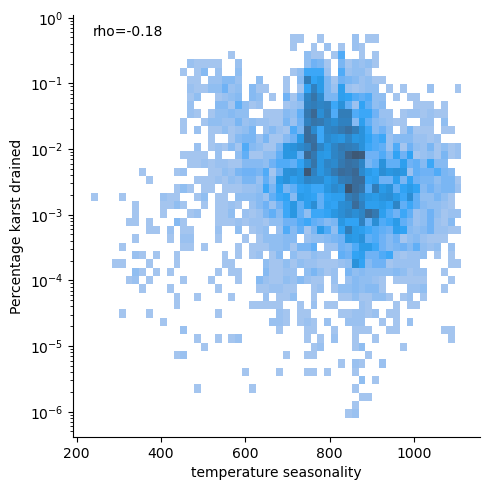

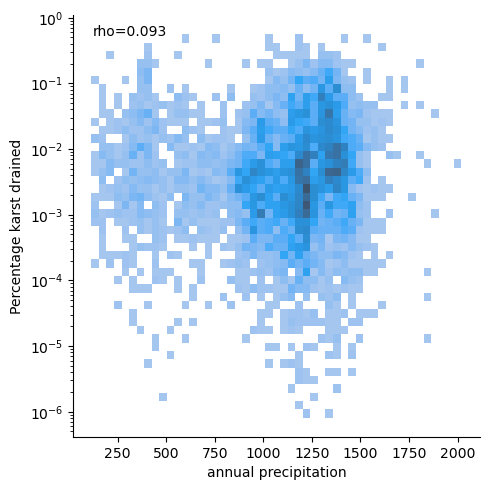

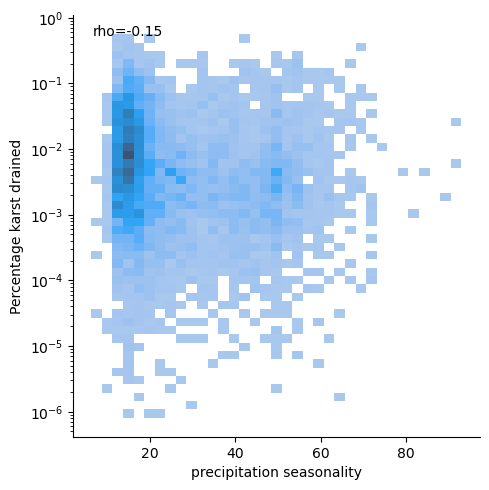

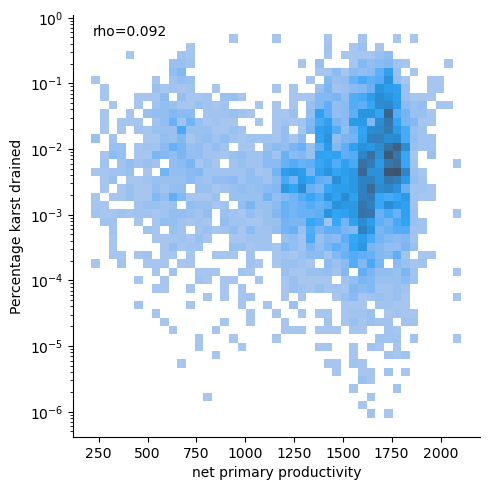

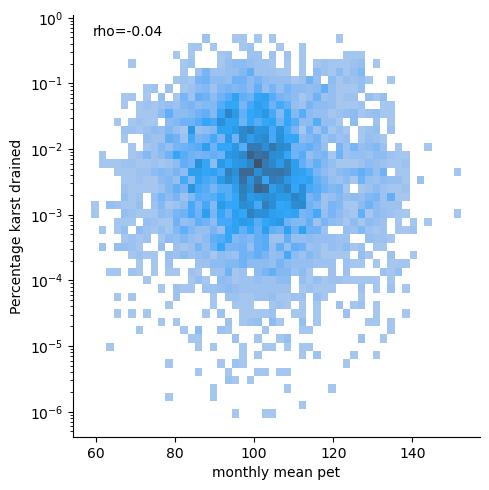

In [15]:
for param in raster_key.index:
     make_displot(param, 
             p_karst.copy(), 
             controls_df,
             trim_zero=True
        )